# Table of Contents

- #### [Imports and data overview](#overview)
    - ####   View static dataset
    - #### Working with Dynamic dataset


### Imports and SparkSession creation

In [30]:
import pandas as pd 
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, col, when, count, avg, round, expr, array, stddev, regexp_extract, substring, when
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
import tensorflow as tf 

#For One Hot Encoding:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, MinMaxScaler

#For visualizing distributions
import seaborn as sns
import matplotlib.pyplot as plt

#warnings.filterwarnings("ignore")

In [2]:
spark = SparkSession.builder.master("local").appName("health").getOrCreate()

24/11/30 18:47:52 WARN Utils: Your hostname, Admins-Mac-mini.local resolves to a loopback address: 127.0.0.1; using 192.168.5.82 instead (on interface en1)
24/11/30 18:47:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/30 18:47:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.setLogLevel("ERROR")

### Get and initially view static Dataset

In [4]:
df = spark.read.csv("health_data_static/gym_members_exercise_tracking.csv", inferSchema=True, header=True)
#Let's view head(3), to see what the dataset we have in question
df.show(n=3)
#Number of rows:
print(f"static number of rows: {df.count()}")

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|
| 46|Female|       74.9|      1.53|    179|    151|         66|                     1.3|          883.0|        HIIT|          33.9|                  2.1|              

In [5]:
#Count # of Nulls: We will not need to worry about transforming out dataset to take care of nulls
df.select([count(when(isnan(col), col)).alias(f"{col}_null") for col in df.columns]).show()

+--------+-----------+----------------+---------------+------------+------------+----------------+-----------------------------+--------------------+-----------------+-------------------+--------------------------+----------------------------------+---------------------+--------+
|Age_null|Gender_null|Weight (kg)_null|Height (m)_null|Max_BPM_null|Avg_BPM_null|Resting_BPM_null|Session_Duration (hours)_null|Calories_Burned_null|Workout_Type_null|Fat_Percentage_null|Water_Intake (liters)_null|Workout_Frequency (days/week)_null|Experience_Level_null|BMI_null|
+--------+-----------+----------------+---------------+------------+------------+----------------+-----------------------------+--------------------+-----------------+-------------------+--------------------------+----------------------------------+---------------------+--------+
|       0|          0|               0|              0|           0|           0|               0|                            0|                   0|        

View more info as aggregate via PySpark functions

In [6]:
df.groupBy("Gender", "Workout_Type").agg( round(avg("Resting_BPM"),1).alias("Average Resting Hear Rate (BPM)"), round(avg("BMI"),1).alias("Average BMI")).show()

+------+------------+-------------------------------+-----------+
|Gender|Workout_Type|Average Resting Hear Rate (BPM)|Average BMI|
+------+------------+-------------------------------+-----------+
|  Male|        Yoga|                           61.8|       26.5|
|Female|      Cardio|                           61.8|       23.0|
|Female|        Yoga|                           61.8|       22.0|
|Female|        HIIT|                           63.0|       22.8|
|  Male|      Cardio|                           62.1|       27.7|
|  Male|        HIIT|                           62.4|       27.4|
|Female|    Strength|                           62.0|       22.9|
|  Male|    Strength|                           62.9|       26.0|
+------+------------+-------------------------------+-----------+



Initially it looks like Females who do Yoga have the lowest BMI and Resting Heart Rate. However, the resting heart rates seem to have very little variation. Let's check it as a distribution and standard devation.

In [7]:
df.select( stddev("Resting_BPM"), stddev("BMI")).show()

+------------------------+-----------------+
|stddev_samp(Resting_BPM)| stddev_samp(BMI)|
+------------------------+-----------------+
|       7.327059908996752|6.660879393631095|
+------------------------+-----------------+



Now we will use SNS to view the distribution

In [8]:
#df_bpm_bmi = df.select( col("Resting_BPM"), df.BMI).toPandas()#['Resting'])
#df_bpm_bmi.head(4)

,Resting_BPM,BMI
0,60,30.20
1,66,32.00
2,54,24.71
3,56,18.41


In [9]:
df_bpm_bmi.describe()

,Resting_BPM,BMI
count,973.000000,973.000000
mean,62.223022,24.912127
std,7.327060,6.660879
min,50.000000,12.320000
25%,56.000000,20.110000
50%,62.000000,24.160000
75%,68.000000,28.560000
max,74.000000,49.840000


/var/folders/vw/nst4t6cs7jb9ygn3ydy2rqwh0000gp/T/ipykernel_48045/1685511334.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_bpm_bmi['Resting_BPM'], color="red", hist=True, rug=True, label='Resting BPM')
/var/folders/vw/nst4t6cs7jb9ygn3ydy2rqwh0000gp/T/ipykernel_48045/1685511334.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147

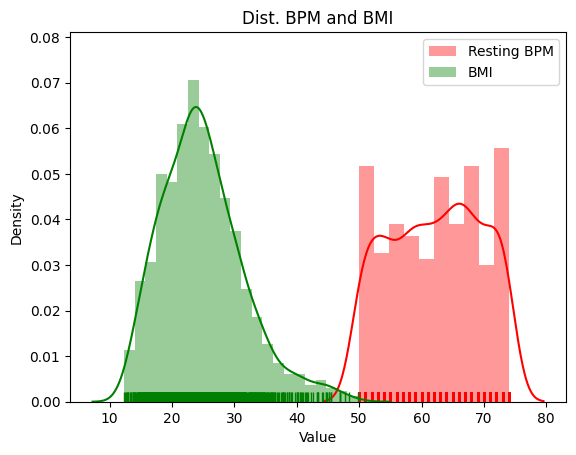

In [10]:
#Let's check the distribution
sns.distplot(df_bpm_bmi['Resting_BPM'], color="red", hist=True, rug=True, label='Resting BPM')
sns.distplot(df_bpm_bmi['BMI'], color="green", hist=True, rug=True, label='BMI')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Dist. BPM and BMI')
plt.show()

The distribution of the resting heart rate is non-normal given the state of the edges. I will assume that there is something wrong with the methodology, data, or the sample is too small. Regardless, we will proceed.

### Static Dataset Cleaning
Let's one hot encode gender and workout type to work on it further:

In [11]:
#We would typically reduce the size of the vectors after one-hot encoding by one to avoid multicolinearity, but vectorAssembler will have issues converting empty sets
indexers= [StringIndexer(inputCol= column, outputCol= column + "Indexed") for column in ['Gender', 'Workout_Type']]
one_hot_encoders = [OneHotEncoder(inputCol = column + "Indexed", outputCol= column+"Encoded", dropLast=False) for column in ['Workout_Type']] #Gender is already in it's reduced form
stages = indexers+one_hot_encoders
pipeline = Pipeline(stages=stages)

model = pipeline.fit(df)
#Let's remove the previous columns that are no longer necessary
df_transformed = model.transform(df).drop("Workout_TypeIndexed", "Workout_Type", "Gender").withColumnRenamed("GenderIndexed", "Gender").withColumnRenamed("Workout_TypeEncoded", "Workout_Type").withColumnRenamed("Gender", "Gender_Female")

In [12]:
#Our new dataset should now be ready for further analysis, and machine learning! The Workout_Type is represented by a set in the form (vector size, [index of vector], [value at index]). Dropping one value improves our ability to develop ML models by reducing the correlation.
df_transformed = df_transformed.withColumn("Workout_Type_String", col("Workout_Type").cast("String"))
df_transformed.select(col("Workout_Type")).show(n=5)

+-------------+
| Workout_Type|
+-------------+
|(4,[2],[1.0])|
|(4,[3],[1.0])|
|(4,[1],[1.0])|
|(4,[0],[1.0])|
|(4,[0],[1.0])|
+-------------+
only showing top 5 rows



In [13]:
size_workout_type = int(df_transformed.select(col("Workout_Type_String")).head()[0][1])
print(f"There are {size_workout_type} workout types, this is correct")

There are 4 workout types, this is correct


We want to get back to a format with separate columns for each workout_type, so we will use a substring to get the value of the index where the value is 1.

In [14]:
df_transformed_3 = df_transformed.withColumn("Workout_Type", regexp_extract(substring(col("Workout_Type_String"), 4,3), r"\d+", 0).cast("Integer"))

As you can see, we now have the index of the 1 values. This let us show the capabilities of regexp_extract, cast, as well as other functions.

In [15]:
df_transformed_3.select("Workout_Type").show(n=3)

+------------+
|Workout_Type|
+------------+
|           2|
|           3|
|           1|
+------------+
only showing top 3 rows



In [17]:
indexer = model.stages[1]
[z for z in enumerate(indexer.labels) ]

[(0, 'Strength'), (1, 'Cardio'), (2, 'Yoga'), (3, 'HIIT')]

In [18]:
workout_map = {index: label for index, label in enumerate(indexer.labels)}
print(workout_map)

{0: 'Strength', 1: 'Cardio', 2: 'Yoga', 3: 'HIIT'}


In [19]:
for n, workout in list(zip(workout_map.keys(), workout_map.values())):
    df_transformed_3 = df_transformed_3.withColumn(f"{workout}_Workout", when(col("Workout_Type") == n, 1).otherwise(0))

Let's look at our transformations!

In [20]:
workout_cols = [col for col in df_transformed_3.columns if "Workout" in col]
df_transformed_3.select([col(x) for x in workout_cols]).show()

+-----------------------------+------------+-------------------+----------------+--------------+------------+------------+
|Workout_Frequency (days/week)|Workout_Type|Workout_Type_String|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|
+-----------------------------+------------+-------------------+----------------+--------------+------------+------------+
|                            4|           2|      (4,[2],[1.0])|               0|             0|           1|           0|
|                            4|           3|      (4,[3],[1.0])|               0|             0|           0|           1|
|                            4|           1|      (4,[1],[1.0])|               0|             1|           0|           0|
|                            3|           0|      (4,[0],[1.0])|               1|             0|           0|           0|
|                            3|           0|      (4,[0],[1.0])|               1|             0|           0|           0|
|               

In [21]:
df_final = df_transformed_3.drop(col("Workout_Type_String"), col("Workout_Type"))

In [23]:
df_final.show(n=2)

+---+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+----+-------------+----------------+--------------+------------+------------+
|Age|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level| BMI|Gender_Female|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|
+---+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+----+-------------+----------------+--------------+------------+------------+
| 56|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|          12.6|                  3.5|                            4|               3|30.2|          0.0|               0|      

Transform vector columns to separate columns

# Creating a model and further analysis

In [24]:
train_set, test_set = df_final.randomSplit([0.8,0.2], seed=11)

Let's apply Min-Max

In [34]:
cols_for_scaling = [col for col in df_final.columns if "_Workout" not in col and "Gender_" not in col]
assembler = VectorAssembler(inputCols= cols_for_scaling, outputCol='vector')
df_final_vectorized = assembler.transform(df_final)

The output vector looks like:

In [38]:
df_final_vectorized.select(col('vector')).show(n=1)

+--------------------+
|              vector|
+--------------------+
|[56.0,88.3,1.71,1...|
+--------------------+
only showing top 1 row



In [ ]:
sc

In [121]:

#assembler = VectorAssembler(inputCols=['Workout_Type'], outputCol='output_Workout')
#assembler.transform(df_transformed).withColumn("x", col("output_Workout").cast("String")).show()
#df_transformed.withColumn("Workout_Type_0", col("Workout_Type").getItem(0)).show()

In [31]:
#indexer = model.stages[1]
#[z for z in enumerate(indexer.labels) ]

[(0, 'Strength'), (1, 'Cardio'), (2, 'Yoga'), (3, 'HIIT')]

In [ ]:
def add_workout_type_columns(df, indexer):
    label_list= indexer.labels
    

In [38]:
for i in range(0,2):
    #Let's get both string indexers from our trained pipeline
    model_indexer = model.stages[0]
    label_list = model_indexer.labels
    #This is not the most elegant process as Gender and Workout_Type are represented in two different formats. But it represents different methods of working with our data. 
    if i == 0:
        for gender, index in list(zip())
        df_transformed.withColumn("Gender", col(""))
    

0
1


In [29]:
df_transformed.toPandas().iloc[:,:4].corr()

,Age,Weight (kg),Height (m),Max_BPM
Age,1.000000,-0.036340,-0.027837,-0.017073
Weight (kg),-0.036340,1.000000,0.365321,0.057061
Height (m),-0.027837,0.365321,1.000000,-0.017660
Max_BPM,-0.017073,0.057061,-0.017660,1.000000


### Goal
From first glance, it appears that Workout_Type and Gender should be one-hot encoded.
The greatest measure of health in my opinion is Resting Heart rate, so let's build a model that attempts to solve for it.

## Sample Streaming Process

In [100]:
#Howerver, let's assume we're working with a dynamic stream. In this case, we choose to append, assuming new additions may be added
schema = StructType( [
    StructField("Age", IntegerType(), True),                StructField("Gender", StringType(), True),
    StructField("Weight_(kg)", FloatType(), True),          StructField("Height_(m)", FloatType(), True),
    StructField("Max_BPM", IntegerType(), True),            StructField("Avg_BPM", IntegerType(), True),
    StructField("Resting_BPM", IntegerType(), True),        StructField("Session_Duration_(hours)", FloatType(), True), 
    StructField("Calories_Burned", FloatType(), True),      StructField("Workout_Type", StringType(), True),
    StructField("Fat_Percentage", FloatType(), True),       StructField("Water_Intake_(liters)", FloatType(), True),
    StructField("Workout_Frequency_(days/week)", IntegerType(), True),
    StructField("Experience_Level", IntegerType(), True),   StructField("BMI", FloatType(), True)
])

df = spark.readStream.schema(schema).csv("health_data")

### Let's view by batch:

Although our streaming directory has two separate data files, the stream consolidates them into one.

In [85]:
def show_head_and_shape(batch_df, batch_id):
    print("2")
    print(f"batch {batch_id} has {batch_df.count()} rows")
    batch_df.show(n=1)
    print("\n")

query = df.writeStream.foreachBatch(show_head_and_shape).start()

One Hot Encoding the inputs. As discussed, Gender and Workout Type should be one hot encoded. To do this, we initially have to apply a StringIndexer as OHE in this case needs to work with numerical values

In [101]:

indexer_gender = StringIndexer(inputCol = "Gender", outputCol="Gender_Index")
ohe_gender = OneHotEncoder(inputCol = "Gender_Index", outputCol = "Gender_Encoded")
pipeline = Pipeline(stages=[indexer_gender, ohe_gender])
#model = pipeline.fit(df)
#
df = indexer.fit(df).transform(df)

AnalysisException: Queries with streaming sources must be executed with writeStream.start();
FileSource[health_data]

In [99]:
df.show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+------------+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|Gender_Index|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+------------+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|         0.0|
| 46|Female|       74.9|      1.53|    179|    151|         66|                     1.3|          883.0|        HIIT

In [81]:
#Show first rows
query = df.writeStream.outputMode("append").format("console").start()

-------------------------------------------
Batch: 0
-------------------------------------------
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight_(kg)|Height_(m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration_(hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake_(liters)|Workout_Frequency_(days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|
| 46|Female|       74.9|      1.53|    179|    151|         66|        

In [45]:
df.count()

AnalysisException: Queries with streaming sources must be executed with writeStream.start();
FileSource[health_data]

In [7]:
df.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Weight (kg): string (nullable = true)
 |-- Height (m): string (nullable = true)
 |-- Max_BPM: string (nullable = true)
 |-- Avg_BPM: string (nullable = true)
 |-- Resting_BPM: string (nullable = true)
 |-- Session_Duration (hours): string (nullable = true)
 |-- Calories_Burned: string (nullable = true)
 |-- Workout_Type: string (nullable = true)
 |-- Fat_Percentage: string (nullable = true)
 |-- Water_Intake (liters): string (nullable = true)
 |-- Workout_Frequency (days/week): string (nullable = true)
 |-- Experience_Level: string (nullable = true)
 |-- BMI: string (nullable = true)



# Overview

In [31]:
[x for x in [1,2,4]]+ [x for x in [4,5,6]]

[1, 2, 4, 4, 5, 6]

In [33]:
[ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]

[StructField('Workout_Type', StringType(), True),
 StructField('Gender', StringType(), True),
 StructField('Age', IntegerType(), True),
 StructField('Weight (kg)', IntegerType(), True),
 StructField('Height (m)', IntegerType(), True),
 StructField('Max_BPM', IntegerType(), True),
 StructField('Avg_BPM', IntegerType(), True),
 StructField('Resting_BPM', IntegerType(), True),
 StructField('Session_Duration (hours)', IntegerType(), True),
 StructField('Calories_Burned', IntegerType(), True),
 StructField('Fat_Percentage', IntegerType(), True),
 StructField('Water_Intake (liters)', IntegerType(), True),
 StructField('Workout_Frequency (days/week)', IntegerType(), True),
 StructField('Experience_Level', IntegerType(), True),
 StructField('BMI', IntegerType(), True)]

In [43]:
#Make into ints/strings
"""
columns = df.columns
string_columns = ['Workout_Type', 'Gender']
schema = StructType(
    [ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]
)
"""

"\ncolumns = df.columns\nstring_columns = ['Workout_Type', 'Gender']\nschema = StructType(\n    [ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]\n)\n"

Count NULLs. There are none.

In [13]:
df.select([count( when( isnan(c), c)).alias(c) for c in df.columns]).show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|  0|     0|          0|         0|      0|      0|          0|                       0|              0|           0|             0|                    0|                            0|               0|  0|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+----------------------

In [22]:
#Save table to catalog
df.write.saveAsTable("health_data")
#Read catalog 
print(spark.catalog.listTables())

[Table(name='health_data', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False)]


In [28]:
temp_df = spark.sql("select _c1, _c2 from health_data limit 3")

In [ ]:
# Count the number of nulls in each column of the dataframe
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

In [25]:
#df.select("Age", "Weight (kg)", "Height (m)").show()
#df.groupBy("Age").count().show()
df.filter(df["Age"]==47).show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 47|Female|       66.8|      1.75|    199|    146|         56|                    1.13|          742.0|    Strength|          32.8|                  2.5|                            3|               2|21.81|
| 47|Female|       58.5|      1.79|    195|    131|         71|                    1.42|          837.0|        Yoga|          30.3|                  2.4|              

As one can see, the columns are set arbitrarily.
Instead, we want to set the first row to the column names

In [30]:
temp_df.toPandas()

,_c1,_c2
0,Gender,Weight (kg)
1,Male,88.3
2,Female,74.9


24/11/19 02:18:27 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 911560 ms exceeds timeout 120000 ms
24/11/19 02:18:27 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/19 02:18:34 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at sc

In [13]:
row_1 = df.collect()[0]

In [14]:
row_1

Row(_c0='Age', _c1='Gender', _c2='Weight (kg)', _c3='Height (m)', _c4='Max_BPM', _c5='Avg_BPM', _c6='Resting_BPM', _c7='Session_Duration (hours)', _c8='Calories_Burned', _c9='Workout_Type', _c10='Fat_Percentage', _c11='Water_Intake (liters)', _c12='Workout_Frequency (days/week)', _c13='Experience_Level', _c14='BMI')